<h3> Malware Classification Using Ember features and Feed Forward Neural Network </h3>


<h4> used a  simple 3-layer feed-forward network with dropout and batch-norm. </h4>
<h5> At the end it can be seen that the training accuracy is 99% and validation accuracy is 92% , and testing accuracy is 92%
    The model is converging in the inital 5 epochs itself. since a malware sample can belongs to multiple classes at the same time. and the label with max probability is considered as true label.the validation and test accuracy around 92% is still good.
    I belive that if we consider top 3 labels then the accuracy can be much improved. </h5>
    
<h5> the corressponding confusion matrix and classification reports and plots can be seen at the end. </h5>
<h6> the architecure implemented here is very simple and more similar to the one in this link: 
    https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab</h6>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [2]:
ember2018 = '../Dataset/ember_zip/ember2018'
test_dataset = np.load(os.path.join(ember2018,'ember2018_test_data.npz'),allow_pickle=True)
X_train,y_train = test_dataset['arr_0'],test_dataset['arr_1']
EPOCHS = 50
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
NUM_FEATURES = 2381
NUM_CLASSES =  2

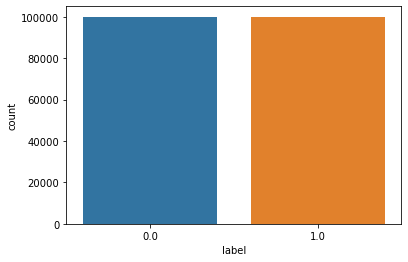

In [4]:
df = pd.DataFrame(data=y_train, columns=["label"])
sns.countplot(x = 'label', data=df);

In [5]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [6]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [7]:

class ClassifierDataset(Dataset):    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]        
    def __len__ (self):
        return len(self.X_data)

class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
values,counts = np.unique(y_train,return_counts=True)
class_weights = 1./torch.tensor(counts, dtype=torch.float) 
print(class_weights)


tensor([1.3889e-05, 1.3889e-05])


In [9]:
train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.astype('float64')).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val.astype('float64')).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.astype('float64')).long())
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)



In [12]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.load_state_dict(torch.load(os.path.join(ember2018,'detection.pth')))
model.eval()
model.to(device)

MulticlassClassification(
  (layer_1): Linear(in_features=2381, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [14]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=2381, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [15]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return (acc)

In [16]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [17]:

for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc =  multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')


Epoch 001: | Train Loss: 0.20881 | Val Loss: 0.69888 | Train Acc: 91.810| Val Acc: 94.388
Epoch 002: | Train Loss: 0.12978 | Val Loss: 0.99220 | Train Acc: 95.153| Val Acc: 95.162
Epoch 003: | Train Loss: 0.09693 | Val Loss: 0.43272 | Train Acc: 96.453| Val Acc: 95.650
Epoch 004: | Train Loss: 0.07583 | Val Loss: 0.44156 | Train Acc: 97.247| Val Acc: 94.781
Epoch 005: | Train Loss: 0.06221 | Val Loss: 0.96631 | Train Acc: 97.780| Val Acc: 95.312
Epoch 006: | Train Loss: 0.05200 | Val Loss: 1.31929 | Train Acc: 98.152| Val Acc: 95.888
Epoch 007: | Train Loss: 0.04470 | Val Loss: 1.15506 | Train Acc: 98.432| Val Acc: 95.856
Epoch 008: | Train Loss: 0.03699 | Val Loss: 1.33602 | Train Acc: 98.701| Val Acc: 96.250
Epoch 009: | Train Loss: 0.03446 | Val Loss: 0.97687 | Train Acc: 98.802| Val Acc: 96.381
Epoch 010: | Train Loss: 0.03075 | Val Loss: 1.55790 | Train Acc: 98.916| Val Acc: 96.306
Epoch 011: | Train Loss: 0.02611 | Val Loss: 1.00609 | Train Acc: 99.106| Val Acc: 93.875
Epoch 012:

In [19]:
torch.save(model.state_dict(), os.path.join(ember2018,'detection.pth'))

In [18]:
os.path.join(ember2018,'detection.pth')

'../Dataset/ember_zip/ember2018/detection.pth'

In [30]:
!ls ../Dataset/sorel/

classification.pth  sorel_label.csv	   test-features.npz
db		    sorel_label_sum25.csv  validation-features.npz
meta.db		    sorel_malware1.csv
sorel_data.npz	    sorel_malware.csv


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

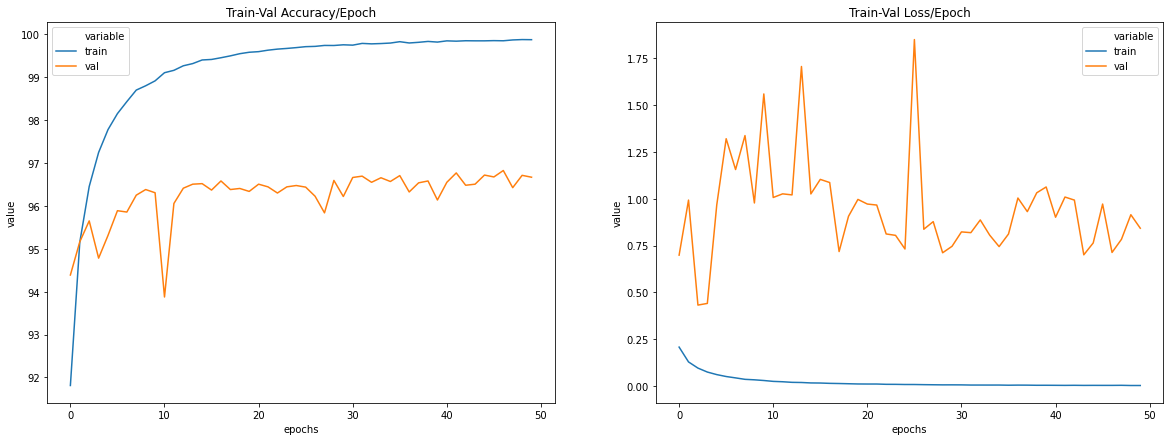

In [20]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [21]:
y_pred_list = []
y_prob_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
         
        y_pred_list.append(y_pred_tags.cpu().numpy())
        y_prob_list.append(y_test_pred)
        
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]


In [33]:
y_prob_list[0],y_pred_list[0]

(tensor([[-15.1259, -23.0870, -25.0988, -23.7968, -21.3749, -21.3992, -19.6963,
          -17.8799,   5.0449, -22.6265, -18.0614]], device='cuda:0'),
 8)

In [22]:
y_test.astype('long')

array([0, 1, 1, ..., 0, 0, 1])

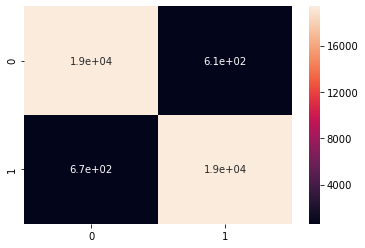

In [23]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test.astype('long'), y_pred_list))

sns.heatmap(confusion_matrix_df, annot=True)

In [24]:
confusion_matrix_df

,0,1
0,19391,609
1,669,19331


In [25]:
print(classification_report(y_test.astype('long'), y_pred_list))


              precision    recall  f1-score   support

           0       0.97      0.97      0.97     20000
           1       0.97      0.97      0.97     20000

    accuracy                           0.97     40000
   macro avg       0.97      0.97      0.97     40000
weighted avg       0.97      0.97      0.97     40000

